# Juan Sebastián Oviedo Mozo

Los códigos presentados aqui son tomados de (https://https://www.kaggle.com/code/akashram/topic-modeling-intro-implementation/notebook). Adicionalmente busqué los ultimos documentos publicados sobre "Topic Modeling" en Google Scholar como guia en cuanto a los métodos usados actualmente para solucionar el problema de "Topic Modeling"

## QUÉ ES EL MODELAMIENTO DE TEMAS (TOPIC MODELING)?

*****
Es un tipo de modelo estadístico para descubrir los "temas" que emergen en una colección de documentos. Un documento suele referirse a múltiples temas en diferentes proporciones; así, en un documento que trata un 10% de gatos y un 90% de perros, probablemente habrá unas 9 veces más palabras de perros que de gatos. Los "temas" producidos por las técnicas de modelización temática son grupos de palabras similares. Un modelo temático recoge esta intuición en un marco matemático, que permite examinar un conjunto de documentos y descubrir, basándose en las estadísticas de las palabras de cada uno, cuáles podrían ser los temas y cuál es el equilibrio de temas de cada documento.
*****

![](https://theintelligenceofinformation.files.wordpress.com/2016/12/topic-modeling-for-learning-analytics-researchers-lak15-tutorial-15-638.jpg)

Los algoritmos de modelado temático más populares son el Análisis Semántico Latente (LSA), también conocido como Indexación Semántica Latente, el Proceso Dirichlet Jerárquico (HDP), la Asignación Dirichlet Latente (LDA) y la Factorización Matricial No Negativa, entre los cuales el LDA ha mostrado grandes resultados en la práctica y, por tanto, ha sido ampliamente adoptado. 

### Importar las librerías importantes y cargar los conjuntos de datos

In [2]:
!pip install pyldavis==2.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.1 MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=c9584313440cd34718f4fc11d6e9a84deee9841540ecdee85d04fe1293ded77f
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyldavis


In [3]:
from sklearn.manifold import TSNE
# NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import re

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns

# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import tqdm

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [5]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [6]:
# NLTK Stop words

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','a','about', 'above', 'across'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Descargar el conjunto de datos

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
output_folder = "data_train_small_dataset/"      # Destination path
output_folder1 = "data_train_small_dataset/train/"      # Destination path
os.makedirs(output_folder , exist_ok=True)
os.makedirs(output_folder1 , exist_ok=True)

In [9]:
!cp -r '/content/drive/MyDrive/PLANET/2020.zip' data_train_small_dataset/


In [10]:
import shutil
shutil.unpack_archive("data_train_small_dataset/2020.zip", "data_train_small_dataset/train/", "zip")

In [11]:
root_path = "data_train_small_dataset/"
all_xml = os.listdir('data_train_small_dataset/train/')
len(all_xml)

13298

In [12]:
all_xml = [ "data_train_small_dataset/train/" + s for s in all_xml]
all_xml[:5]

['data_train_small_dataset/train/2020842.xml',
 'data_train_small_dataset/train/2023420.xml',
 'data_train_small_dataset/train/2011444.xml',
 'data_train_small_dataset/train/2049522.xml',
 'data_train_small_dataset/train/2002410.xml']

In [13]:
all_xml[1]

'data_train_small_dataset/train/2023420.xml'

In [14]:
import pandas as pd
import xml.etree.ElementTree as et

def parse_XML(xml_file, df_cols): 
    """Parse the input XML file and store the result in a pandas 
    DataFrame with the given columns. 
    
    The first element of df_cols is supposed to be the identifier 
    variable, which is an attribute of each node element in the 
    XML data; other features will be parsed from the text content 
    of each sub-element. 
    """
    uno = xml_file
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []
    
    for node in xroot: 
        res = []
        res.append( node.attrib.get(df_cols[0]))
        for el in df_cols[1:]: 
            if node is not None and node.find(el) is not None:
                res.append(node.find(el).text)
            else: 
                res.append(None)
        rows.append({df_cols[i]: res[i] 
                     for i, _ in enumerate(df_cols)})
    
    out_df = pd.DataFrame(rows, columns=df_cols)
    out_df["file"]  = uno.split("/")[-1]   
    return out_df

Concatenar por filas hacia abajo todos los registros de cada uno de los archivos .xml

Solo conservamos 3 variables: Code, AwardTitle, AbstractNarration 

In [15]:

appended_data = []
for file in all_xml:
    data = parse_XML(file, ["Code","AwardTitle","AbstractNarration"])
    # store DataFrame in list
    appended_data.append(data)
# see pd.concat documentation for more info
appended_data = pd.concat(appended_data)    

In [16]:
data = appended_data
#data = appended_data.drop('Code', axis=1)
data.drop('Code', axis=1, inplace=True)

In [17]:
data.columns

Index(['AwardTitle', 'AbstractNarration', 'file'], dtype='object')

In [18]:
data.head(10)

,AwardTitle,AbstractNarration,file
0,Thermal imaging with ultrafine spatial resolut...,From cell phones to laptops to the internet of...,2020842.xml
0,RUI: Collaborative Research: Cleaning stations...,Biodiversity in the ocean is influenced by int...,2023420.xml
0,Numerical Analysis and Methods for Fluid Defor...,Fluid surfaces that deform are ubiquitous in c...,2011444.xml
0,Collaborative Research: A Laboratory Experimen...,This project is motivated by the need to impro...,2049522.xml
0,Charting Arctic and Global Interconnections: W...,Arctic biophysical and climate systems are dee...,2002410.xml
0,Collaborative Research: IRNC: Testbed: FAB: FA...,"Global science relies on robust, interconnecte...",2029176.xml
0,Doctoral Dissertation Research: Food security ...,This project examines shifting discourse and p...,2001744.xml
0,Unraveling posture control in severe cerebral ...,The vast majority of research in cerebral pals...,2015660.xml
0,Collaborative Research: Mathematics Graduate T...,This project aims to serve the national intere...,2013563.xml
0,Collaborative Research: SaTC: CORE: Small: Exp...,"Nowadays, vast amounts of individual informati...",2055564.xml


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13298 entries, 0 to 0
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   AwardTitle         13298 non-null  object
 1   AbstractNarration  13157 non-null  object
 2   file               13298 non-null  object
dtypes: object(3)
memory usage: 415.6+ KB


### Reducir el conjunto de datos

Seleccionar filas de muestra de todas las categorías (en este caso, temas) para que los cálculos sean más rápidos. 

Ahora que tenemos nuestro conjunto de datos cargado, tenemos que limpiar el texto para mejorar cualquier esfuerzo de agrupación o clasificación. En primer lugar, vamos a eliminar los valores nulos:


In [20]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13157 entries, 0 to 0
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   AwardTitle         13157 non-null  object
 1   AbstractNarration  13157 non-null  object
 2   file               13157 non-null  object
dtypes: object(3)
memory usage: 411.2+ KB


Se eliminan 141 registros con información faltante.

Descargar spacy bio parser

In [21]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 500.6 MB 11 kB/s 
  Created wheel for en-core-sci-lg: filename=en_core_sci_lg-0.2.4-py3-none-any.whl size=501343162 sha256=2b99269097ad3441f1e236284630e592bf195c58eadf6467d8d149fbbcf86eb8
  Stored in directory: /root/.cache/pip/wheels/06/a3/b5/bacce7d280488beaf177c3eadbe9f440244201544a0461f6f3
Successfully built en-core-sci-lg


In [22]:
!pip install spaCy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

/usr/local/lib/python3.7/dist-packages/spacy/util.py:885: UserWarning: [W094] Model 'en_core_sci_lg' (0.2.4) specifies an under-constrained spaCy version requirement: >=2.2.1. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.4.2,<3.5.0
  warnings.warn(warn_msg)


#Stop words
Parte del preprocesamiento consistirá en encontrar y eliminar las stopwords (palabras comunes que actuarán como ruido en la etapa de clustering).

Ahora bien, las siguientes stopwords se utilizan en el texto cotidiano en inglés. En los trabajos de investigación se utilizan a menudo palabras que no contribuyen al significado y que no se consideran stopwords cotidianas.




In [24]:

import string
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['others',
 "'re",
 'bottom',
 'does',
 'above',
 'latterly',
 'wherein',
 'make',
 'upon',
 'further']

# Stop words definidas manualmente

In [25]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

###A continuación vamos a crear una función que procese los datos de texto.
Para ello, utilizaremos la biblioteca spacy. Esta función convertirá el texto a minúsculas, eliminará los signos de puntuación y encontrará y eliminará las palabras clave. Para el analizador sintáctico, utilizaremos en_core_sci_lg. Se trata de un modelo para procesar texto biomédico, científico o clínico.

In [26]:
!pip install scispacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44 kB 1.8 MB/s 
     |████████████████████████████████| 71 kB 4.3 MB/s 
     |████████████████████████████████| 13.5 MB 18.2 MB/s 
     |████████████████████████████████| 188 kB 54.5 MB/s 


In [27]:
!python -m spacy download en_core_web_lg

2022-11-09 01:01:10.454843: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 16 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [28]:
# Parser
import scispacy
import spacy
parser = spacy.load("en_core_web_lg")
#parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

Aplicar la función de tratamiento de texto en la variable **AbstractNarration**.

In [29]:
from tqdm import tqdm
tqdm.pandas()
data["processed_text"] = data["AbstractNarration"].progress_apply(spacy_tokenizer)

100%|██████████| 13157/13157 [22:18<00:00,  9.83it/s]


**Vectorización**

Ahora que hemos preprocesado los datos, es el momento de convertirlos en un formato que pueda ser manejado por el algoritmo. Para ello, utilizaremos tf-idf. Esto Convierte nuestros datos con formato de cadena en una medida de la importancia de cada palabra en la instancia de la literatura en su conjunto.


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

Vectorizar nuestros datos. Haremos un clustering basado en el contenido del cuerpo del texto. El número máximo de características será el número máximo de palabras únicas de todos los documentos

In [31]:
text = data['processed_text'].values
max_features = 2**12

X = vectorize(text, max_features)

**PCA & Clustering**

Vamos a ver cuánto podemos reducir las dimensiones manteniendo el 95% de varianza. Aplicaremos el análisis de componentes principales (PCA) a nuestros datos vectorizados. Esto reducirá la complejidad de nuestro paso de reducción de la dimensionalidad y filtrará el ruido.

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(13157, 2665)

Para separar la literatura, se ejecutará k-means en el texto vectorizado. Dado el número de clusters, k, k-means clasificará cada vector tomando la distancia media a un centroide inicializado aleatoriamente. Los centroides se actualizan de forma iterativa

In [33]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

##¿Cuántos clusters?

Para encontrar el mejor valor de k para k-means miraremos la distorsión a diferentes valores de k. La distorsión calcula la suma de las distancias al cuadrado de cada punto a su centro asignado. Cuando la distorsión se traza contra k habrá un valor de k después del cual las disminuciones en la distorsión son mínimas. Este es el número deseado de clusters.


In [34]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Found distortion for {} clusters'.format(k))

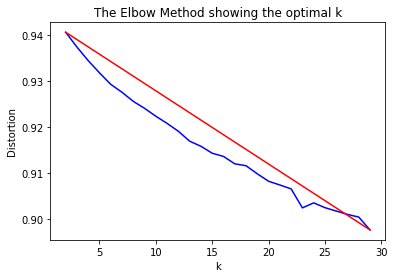

In [35]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Seleccionamos k = 24 componentes principales

In [37]:
k = 24
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
data['y'] = y_pred

**Reducción de la dimensionalidad con t-SNE**

Usando t-SNE podemos reducir nuestro vector de características de alta dimensión a 2 dimensiones. Utilizando las 2 dimensiones como coordenadas x,y, el cuerpo_texto puede ser trazado. t-SNE intentará preservar las relaciones de los datos de alta dimensión tan estrechamente como sea posible cuando se reduzca a 2D. Así, los artículos similares estarán más cerca unos de otros.


In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=50)  # Changed perplexity from 100 to 50 per FAQ
X_embedded = tsne.fit_transform(X.toarray())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 13157 samples in 0.048s...
[t-SNE] Computed neighbors for 13157 samples in 63.064s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13157
[t-SNE] Computed conditional probabilities for sample 2000 / 13157
[t-SNE] Computed conditional probabilities for sample 3000 / 13157
[t-SNE] Computed conditional probabilities for sample 4000 / 13157
[t-SNE] Computed conditional probabilities for sample 5000 / 13157
[t-SNE] Computed conditional probabilities for sample 6000 / 13157
[t-SNE] Computed conditional probabilities for sample 7000 / 13157
[t-SNE] Computed conditional probabilities for sample 8000 / 13157
[t-SNE] Computed conditional probabilities for sample 9000 / 13157
[t-SNE] Computed conditional probabilities for sample 10000 / 13157
[t-SNE] Computed conditional probabilities for sample 11000 / 13157
[t-SNE] Computed conditional probabilities for sample 12000 / 13157
[t-SNE] Computed conditional probabilities for s

Así que este paso ha llevado un tiempo. Veamos qué aspecto tienen nuestros datos cuando se comprimen en 2 dimensiones.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


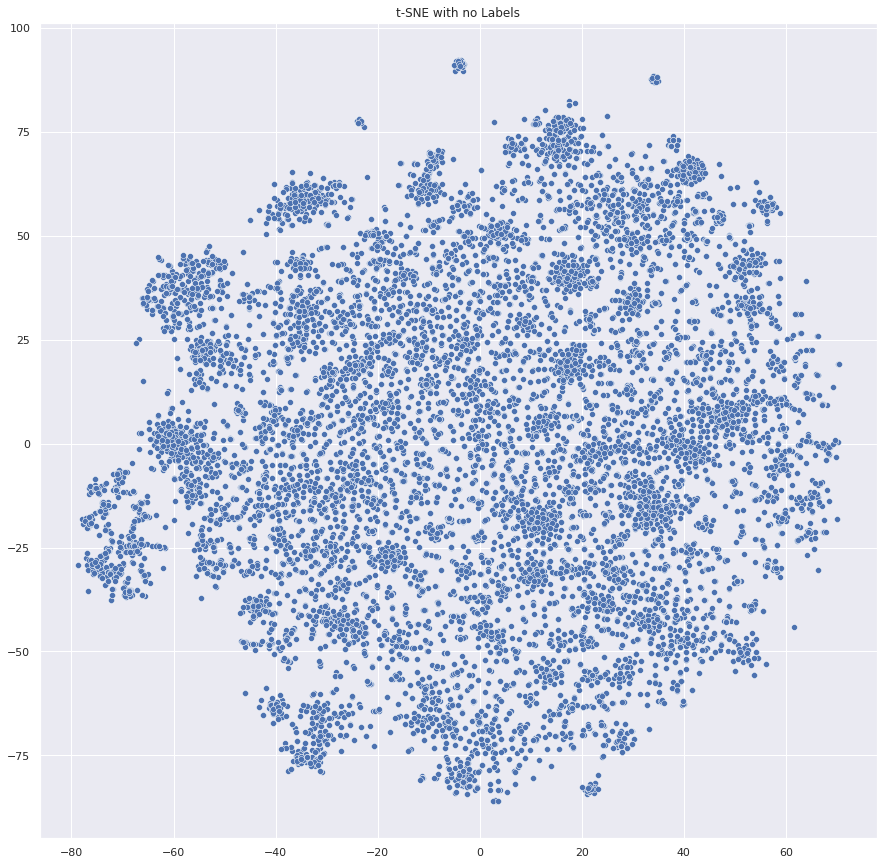

In [39]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

Esto parece bastante suave. t-SNE fue capaz de reducir la dimensionalidad de los textos, pero ahora es necesario el clustering.
Utilicemos los clusters encontrados por k-means como etiquetas. Esto ayudará a separar visualmente las diferentes concentraciones de temas.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


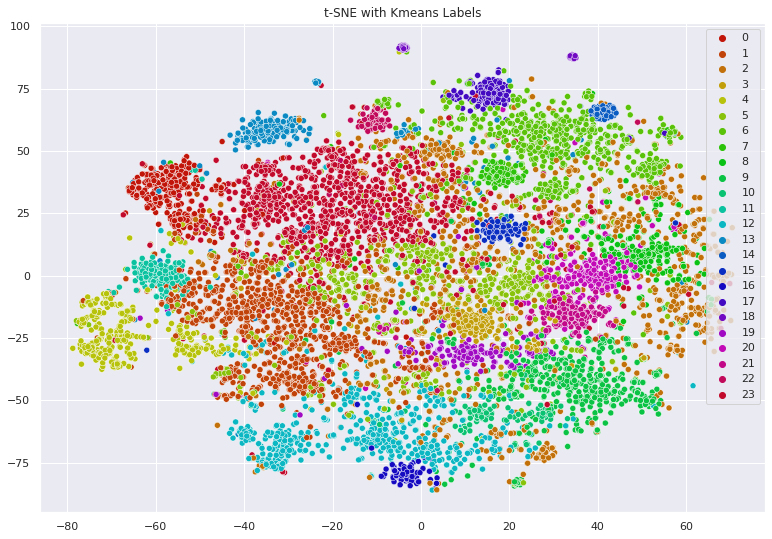

In [46]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(24, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

El gráfico etiquetado permite comprender mejor cómo se agrupan los artículos. Resulta interesante que tanto k-means como t-SNE puedan encontrar agrupaciones independientes aunque se hayan ejecutado de forma independiente. Esto demuestra que la estructura dentro de la literatura puede ser observada y medida hasta cierto punto.

Ahora bien, hay otros casos en los que las etiquetas de color están dispersas en el gráfico. Esto es el resultado de que t-SNE y k-means encuentren diferentes conexiones en los datos de mayor dimensión. Los temas de estos trabajos a menudo se cruzan, por lo que fue difícil separarlos limpiamente.

**Modelación del tema en cada cluster**

Ahora intentaremos encontrar las palabras más significativas de cada clúster. K-means agrupó los artículos pero no etiquetó los temas. Mediante el modelado de temas, averiguaremos cuáles son los términos más importantes de cada clúster. Esto añadirá más significado al clúster al proporcionar palabras clave para identificar rápidamente los temas del clúster.

Para el modelado de temas, utilizaremos LDA (Latent Dirichlet Allocation). En LDA, cada documento puede ser descrito por una distribución de temas y cada tema puede ser descrito por una distribución de palabras.

<a id='lda'></a>

# Latent Dirichlet Allocation

### Generación de Topicos

LSI examina las palabras utilizadas en un documento y busca sus relaciones con otras palabras. LSI permite determinar las palabras para las que un documento puede ser relevante, incluso si no se utilizan realmente en el propio documento.  Pero si el contenido está lleno de palabras que tienen relaciones entre sí, se está reforzando el documento para todas esas palabras.
        
LDA aborda la ambigüedad comparando un documento con los temas y determinando qué tema está más cerca del documento, a través de todas las combinaciones de temas que parecen ampliamente relevantes. De este modo, el LDA ayuda a determinar qué documentos son más relevantes para qué temas. En LDA las palabras se agrupan en temas. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Latent_Dirichlet_allocation.svg/293px-Latent_Dirichlet_allocation.svg.png)


***
* α es el parámetro de la probabilidad a priori Dirichlet sobre las distribuciones de temas por documento,

* β es el parámetro de la probabilidad a prior Dirichlet para la distribución de palabras por tema,

* $ \theta _{m}$ es la distribución de temas para el documento m

* $\varphi _{k}$ es la distribución de palabras para el tema k

* $z_{mn}$ es el tema de la n-ésima palabra del documento m

* $w_{mn}$ es la palabra específica.

***
El hecho de que W esté en gris significa que las palabras $w_{ij}$ son las únicas variables observables, y las demás variables son variables latentes. Para modelar la distribución tema-palabra se puede utilizar una distribución a priori Dirichlet dispersa, siguiendo la intuición de que la distribución de probabilidad sobre las palabras de un tema está sesgada, de modo que sólo un pequeño conjunto de palabras tiene una alta probabilidad. El modelo resultante es la variante de LDA más aplicada en la actualidad. La notación de la placa para este modelo se muestra a continuación, donde $K$ denota el número de temas y $\varphi_{1},\dots ,\varphi_{K}$ son vectores $V$-dimensionales que almacenan los parámetros de las distribuciones tema-palabra distribuidas por Dirichlet ( $V$ es el número de palabras en el vocabulario).

Es útil pensar en las entidades representadas por $\theta$ y $\varphi$ como matrices creadas mediante la descomposición de la matriz documento-palabra original que representa el corpus de documentos que se está modelando. Desde este punto de vista, $\displaystyle \theta$ consta de filas definidas por documentos y columnas definidas por temas, mientras que $\varphi$ consta de filas definidas por temas y columnas definidas por palabras. Así, $\varphi _{1},\dots ,\varphi _{K}$ se refiere a un conjunto de filas, o vectores, cada uno de los cuales es una distribución sobre palabras, y $\theta_{1},\dots ,\theta_{M}$ se refiere a un conjunto de filas, cada una de las cuales es una distribución sobre temas.

***

![](https://upload.wikimedia.org/wikipedia/commons/4/4d/Smoothed_LDA.png)


LDA asume que cada documento de un corpus contiene una mezcla de temas que se encuentran en todo el corpus. La estructura temática está oculta: sólo podemos observar los documentos y las palabras, no los temas en sí. Dado que la estructura está oculta (también conocida como latente), este método trata de inferir la estructura temática a partir de las palabras y los documentos conocidos.

LDA representa los documentos como mezclas de temas que generan palabras con ciertas probabilidades. Asume que los documentos se producen de la siguiente manera: 

***
* Decide el número de palabras N que tendrá el documento.
* Elegir una mezcla de temas para el documento (según una distribución de probabilidad Dirichlet sobre un conjunto fijo de K temas). 
* Generar cada palabra del documento:
    * Primero escogiendo un tema.
    * A continuación, utilizar el tema para generar la propia palabra (de acuerdo con la distribución multinomial del tema).
    * Asumiendo este modelo generativo para una colección de documentos, LDA intenta entonces retroceder desde los documentos para encontrar un conjunto de tópicos que probablemente hayan generado la colección.
***

Preprocesamiento

 Una vez el modelo LDA está construido, hay una métrica para evaluar lo bueno que es el modelo.


## Hay 2 métricas de este tipo. 

1) Perplejidad - Es una medida estadística de lo bien que un modelo de probabilidad predice una muestra. Aplicado a LDA, para un valor dado de k, se estima el modelo LDA. Luego, dada la distribución teórica de palabras representada por los temas, se compara con las mezclas de temas reales, o la distribución de palabras en los documentos. - Cuanto más bajo, mejor.

 2) Puntuación de coherencia - Se define como la media/mediana de las puntuaciones de similitud de palabras por pares en el tema - Cuanto más alta, mejor.

**Interpretemos la visualización de los temas**

Fíjate en que los temas se muestran a la izquierda y las palabras a la derecha.


Estos son los principales aspectos que debes tener en cuenta:

* Los temas más grandes son más frecuentes en el corpus.
* Los temas más cercanos son más similares, los temas más alejados son menos similares.
* Cuando seleccionas un tema, puedes ver las palabras más representativas del tema seleccionado. Esta medida puede ser una combinación de la frecuencia o el grado de discriminación de la palabra.
* Puedes ajustar el peso de cada propiedad usando el deslizador.
* Al pasar el ratón por encima de una palabra, se ajustará el tamaño de los temas en función de su representatividad.
                          



In [41]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

En primer lugar, crearemos 24 vectorizer, uno para cada una de nuestras etiquetas de cluster

In [42]:
vectorizers = []
    
for ii in range(0, 24):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

Ahora vamos a vectorizar los datos de cada uno de nuestros clusters

In [43]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(data.loc[data['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [44]:
len(vectorized_data)

24

El modelado de temas se realizará mediante el uso de la Asignación de Dirichlet Latente (LDA). Se trata de un modelo estadístico generativo que permite explicar conjuntos de palabras mediante un tema compartido

In [49]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 24


lda_models = []

for ii in range(0, 24):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=24,
                          random_state=42, verbose=False)

Para cada cluster, habíamos creado un modelo LDA correspondiente en el paso anterior. Ahora vamos a ajustar_transformar todos los modelos LDA en sus respectivos vectores de cluster


In [50]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19
Current Cluster: 20
Current Cluster: 21
Current Cluster: 22
Current Cluster: 23


Extracts the keywords from each cluster

In [51]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

In [52]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19
Current Cluster: 20
Current Cluster: 21
Current Cluster: 22
Current Cluster: 23


**Guardar los resultados actuales en un archivo**.

Volver a ejecutar algunas partes del cuaderno (especialmente la vectorización y el t-SNE) son tareas que requieren mucho tiempo. Queremos asegurarnos de que las salidas importantes para generar el gráfico bokeh se guardan para su uso futuro.

In [53]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [54]:
import pickle

# save the topics DataFrame
pickle.dump(data, open("df_topic.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("y_pred.p", "wb" ))

**Clasificar**

Aunque es arbitrario, después de ejecutar kmeans, los datos están ahora "etiquetados". Esto significa que ahora utilizamos el aprendizaje supervisado para ver lo bien que se generaliza la agrupación. Esta es sólo una forma de evaluar la agrupación. Si k-means fue capaz de encontrar una división significativa en los datos, debería ser posible entrenar un clasificador para predecir a qué cluster debería pertenecer una instancia dada.

In [55]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [56]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 10525
X_test size: 2632 



Ahora vamos a crear un clasificador de Descenso Gradiente Estocástico

La **precisión** es la relación entre los verdaderos positivos y los falsos positivos. Es la precisión de las predicciones positivas

La **recuperación** (también conocida como TPR) mide la relación entre Verdaderos Positivos y Verdaderos Positivos + Falsos Negativos. Mide la proporción de instancias positivas que son detectadas correctamente por el clasificador.

El **F1-score** es la media armónica de la precisión y la recuperación. La puntuación F1 sólo será alta si la precisión y la recuperación son altas.

In [57]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=-1)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  91.515 %
     Precision:  93.477 %
        Recall:  91.774 %
      F1 score:  92.550 %


Para comprobar si hay sobreajuste, veamos cómo generaliza el modelo en el conjunto de pruebas

In [58]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=-1)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  87.918 %
     Precision:  91.227 %
        Recall:  87.094 %
      F1 score:  88.919 %


Ahora veamos cómo el modelo puede generalizar en todo el conjunto de datos.

In [59]:
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

Mean cv Score - SGD: 92.970 %


**graficar los datos**

Los pasos anteriores nos han proporcionado etiquetas de agrupación y un conjunto de datos de artículos reducidos a dos dimensiones. Al combinar esto con Bokeh, podemos crear un gráfico interactivo de la literatura. Esto debería organizar los artículos de manera que las publicaciones relacionadas estén cerca. Para tratar de entender cuáles son las similitudes, también hemos realizado un modelado de temas en cada grupo de artículos para seleccionar los términos clave.

En primer lugar, vamos a descargar nuestros scripts del repositorio que contiene la configuración del gráfico y el texto:

In [60]:
!wget https://raw.githubusercontent.com/MaksimEkin/COVID19-Literature-Clustering/master/lib/plot_text.py
!wget https://raw.githubusercontent.com/MaksimEkin/COVID19-Literature-Clustering/master/lib/call_backs.py
!mv plot_text.py lib/.
!mv call_backs.py lib/.
!ls 

--2022-11-09 02:45:36--  https://raw.githubusercontent.com/MaksimEkin/COVID19-Literature-Clustering/master/lib/plot_text.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5703 (5.6K) [text/plain]
Saving to: ‘plot_text.py’

plot_text.py        100%[===================>]   5.57K  --.-KB/s    in 0s      

2022-11-09 02:45:36 (63.3 MB/s) - ‘plot_text.py’ saved [5703/5703]

--2022-11-09 02:45:36--  https://raw.githubusercontent.com/MaksimEkin/COVID19-Literature-Clustering/master/lib/call_backs.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 O

required libraries for plot

In [61]:
!pip install bokeh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
from plot_text import header, description, description2, cite, description_search, description_slider, notes, dataset_description, toolbox_header 
from call_backs import input_callback, selected_code
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

Load the Keywords per Cluste

In [63]:
import os

topic_path = os.path.join(os.getcwd(), 'topics.txt')
with open(topic_path) as f:
    topics = f.readlines()

In [68]:
# show on notebook
output_notebook()
# target labels
y_labels = y_pred

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= data['AwardTitle'],
    #authors = data['authors'],
    #journal = data['journal'],
    files = data['file'],
    abstract = data['AbstractNarration'],
    labels = ["C-" + str(x) for x in sorted(y_labels)],
    #links = df['doi']
    ))


# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Archivo", "@files{safe}"),
   # ("Author(s)", "@authors{safe}"),
   # ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
   # ("Link", "@links")
],
point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
plot = figure(plot_width=1200, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering National Science Foundation with t-SNE and K-Means", 
           toolbar_location="above")

# plot settings
plot.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6

WIDGETS

In [69]:
# Keywords
text_banner = Paragraph(text= 'Keywords: Slide to specific cluster to see the keywords.', height=25)
input_callback_1 = input_callback(plot, source, text_banner, topics)

# currently selected article
div_curr = Div(text="""Click on a plot to see the link to the article.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr),
                             code=selected_code())

taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# WIDGETS
slider = Slider(start=0, end=26, value=0, step=1, title="Cluster #")
keyword = TextInput(title="Search:")

# pass call back arguments
input_callback_1.args["text"] = keyword
input_callback_1.args["slider"] = slider


Style


In [70]:
# STYLE
header.sizing_mode = "stretch_width"
header.style={'color': '#2e484c', 'font-family': 'Julius Sans One, sans-serif;'}
header.margin=5

description.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description.sizing_mode = "stretch_width"
description.margin = 5

description2.sizing_mode = "stretch_width"
description2.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description2.margin=10

description_slider.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description_slider.sizing_mode = "stretch_width"

description_search.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description_search.sizing_mode = "stretch_width"
description_search.margin = 5

slider.sizing_mode = "stretch_width"
slider.margin=15

keyword.sizing_mode = "scale_both"
keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "stretch_width"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 5

dataset_description.sizing_mode = "stretch_width"
dataset_description.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
dataset_description.margin=10

notes.sizing_mode = "stretch_width"
notes.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
notes.margin=10

cite.sizing_mode = "stretch_width"
cite.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
cite.margin=10

r = row(div_curr,text_banner)
r.sizing_mode = "stretch_width"

SHOW

In [ ]:
# LAYOUT OF THE PAGE
l = layout([
    #[header],
    #[description],
    [description_slider, description_search],
    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot],
    #[description2, dataset_description, notes, cite],
])
l.sizing_mode = "scale_both"


# show
output_file('t-sne_covid-19_interactive.html')
show(l)

El gráfico no se pude cargar porque es bastante pesado, sin embargo, en él se puede observar cada uno de los 26 cluster definidos previamente, tambien se puede observar el conjunto de palabras que están más asociadas a cada cluster, de esta manera se puede describir el tema de cada cluster con respecto a las palabras que lo componen.

In [72]:
X_embedded1 = pd.DataFrame(X_embedded, columns=['xx', 'yy'])
y_pred1 = pd.DataFrame(y_pred, columns=['grp'])

In [73]:
df = pd.concat([X_embedded1, y_pred1], axis=1)


In [74]:
df.head(10)

,xx,yy,grp
0,-38.570885,-22.079090,1
1,22.676098,-81.684189,9
2,-53.731510,19.218102,0
3,-14.503293,-39.445084,12
4,27.671101,-70.045357,2
5,-12.099095,48.317905,23
6,59.142586,-17.909939,2
7,51.823475,32.600227,2
8,29.834839,57.176929,6
9,-15.830123,31.745422,23


In [86]:
df1 = df[(df.grp == 0) ]

In [87]:
df1.head(10)

,xx,yy,grp
2,-53.731510,19.218102,0
27,-49.698765,20.138329,0
32,-65.039070,37.074776,0
152,-53.529255,46.562363,0
156,-55.366714,17.153105,0
191,-64.075172,37.303555,0
242,-53.173279,43.251961,0
265,-61.052616,36.225933,0
267,-54.088703,23.645525,0
307,-55.570572,37.278873,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


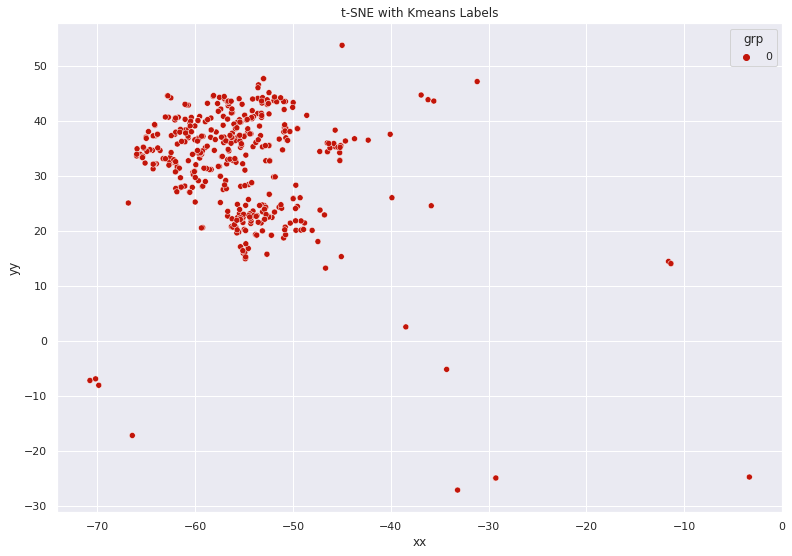

study, space, geometry, model, group, function, homology, dimensional, operator, knot, graph, curvature, representation, ring, surface, variety, symmetry, class, integral, minimal, symplectic, hodge, singularity, characteristic, enumerative, manifold, field, real, category, sensing, plane, couple, geometrically, pis, response, functor, theory, algebra, new, solution, algebraic, problem, hole, develop, analysis, equation, research, fluid, dynamic, student, nuclear



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


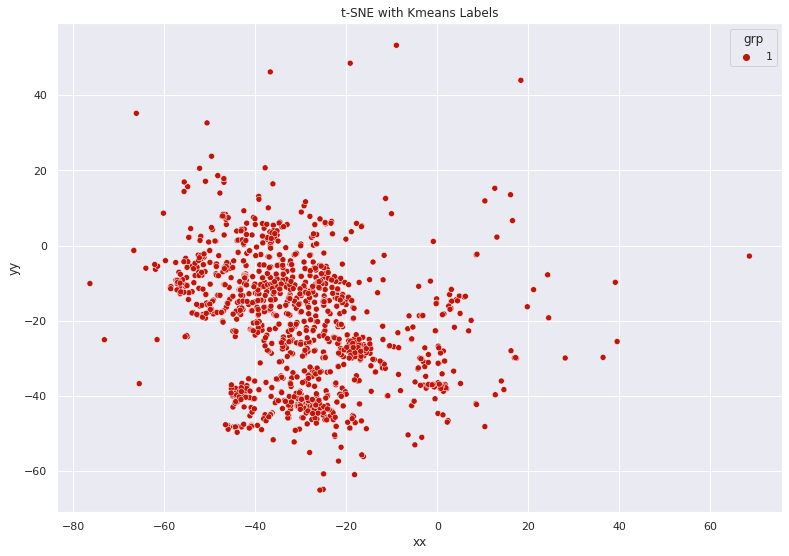

student, manufacturing, polymer, device, surface, chemical, project, reaction, catalyst, nanoparticle, active, battery, thermal, material, model, ion, spin, magnetic, particle, heat, center, porous, solar, crystal, perovskite, transfer, flow, university, silver, mineral, lattice, materials, movement, wall, motor, diamond, nanowire, corrosion, domain, atom, antiviral, bird, portfolio, infuse, stress, comb, research, microtubule, frequency, light, scale, transition, infrared, detection



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


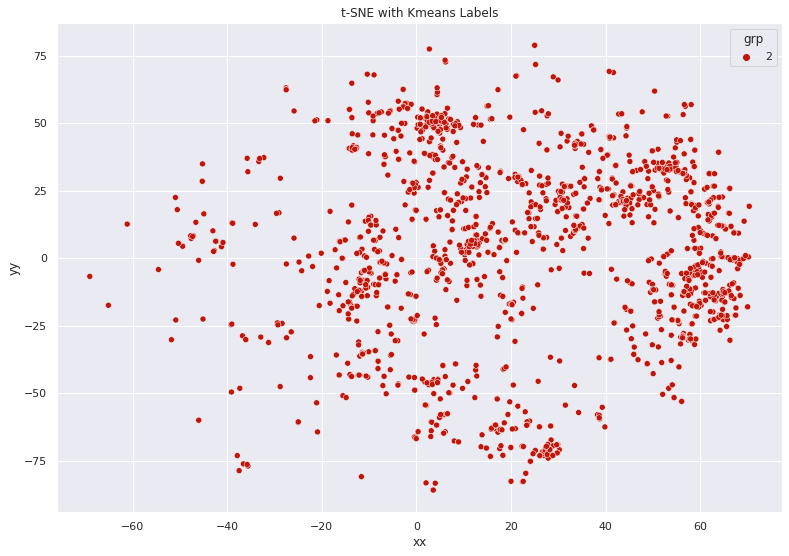

community, datum, language, project, research, decision, child, brain, study, water, human, indigenous, model, policy, energy, student, speech, building, market, flow, sample, control, quality, information, university, arctic, air, task, ethical, knowledge, firm, crop, ecosystem, ethic, fluid, financial, migration, infant, recognition, synchrony, freshwater, identification, ses, production, fly, word, nitrogen, swarm, migrant, movement, macro, arena, conversation, documentary, synoptic, reinforce, mask, face, design



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


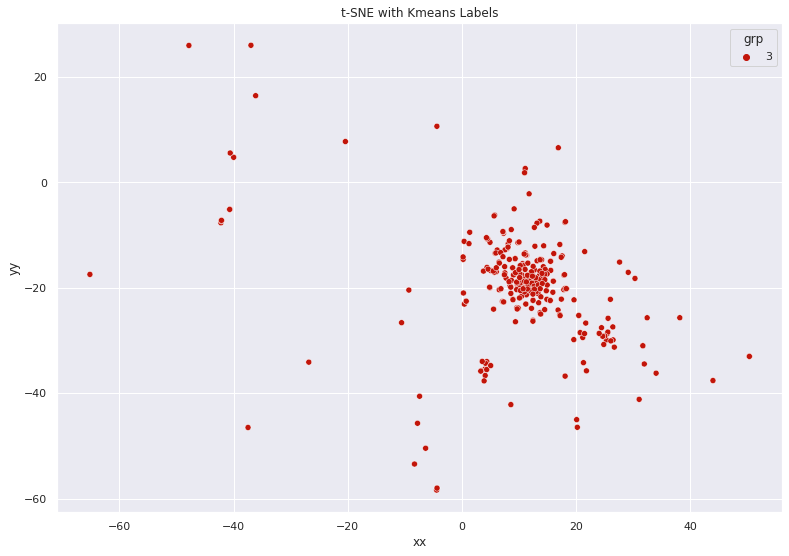

research, develop, tissue, student, model, technology, root, force, chromosome, zone, growth, actin, wound, efficiency, cartilage, chromatin, healing, dna, mechanical, material, biology, mitochondrial, light, live, nanomaterial, workshop, body, gene, energy, metabolic, meeting, work, human, antibiotic, power, metabolism, stem, insulin, biologist, bacterial, differentiation, city, laboratory, culture, gradient, acid, bio, collaboration, making, progenitor, american, polarization, sample, collection, datum, membrane, design, solar, component, study, stiffness



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


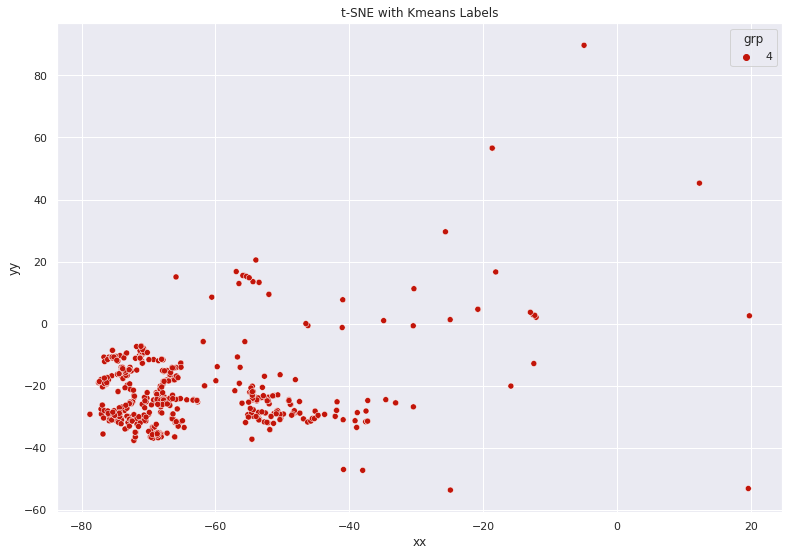

galaxy, research, plasma, matter, hole, black, detector, energy, project, star, wave, gravitational, coating, space, noise, ray, mirror, ionosphere, ionospheric, cloud, magnetic, water, gas, reconnection, model, cosmic, ion, density, gamma, comet, propagation, method, investigator, survey, solar, team, new, datum, spectroscopic, physics, high, facility, massively, particle, collision, need



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


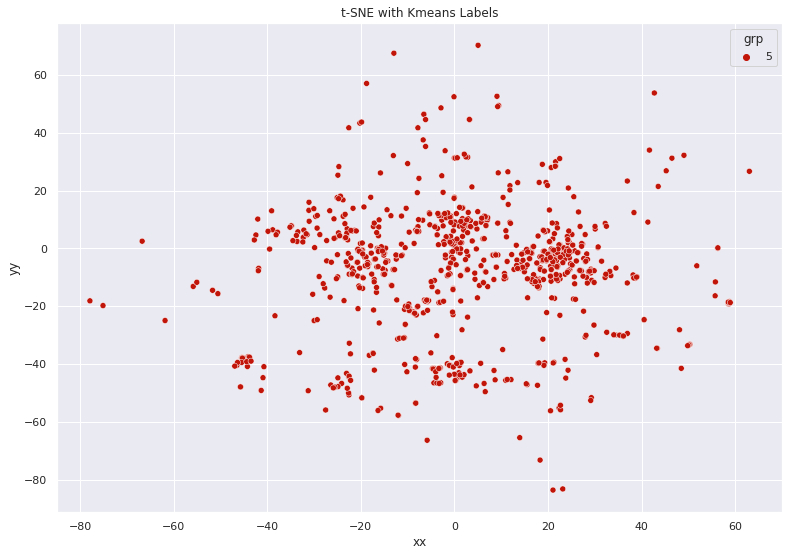

patient, phase, device, power, cost, reduce, propose, high, energy, cancer, battery, solar, imaging, image, display, gas, membrane, panel, satellite, ion, lithium, light, drone, joint, cell, video, traffic, plastic, security, robotic, pathology, antenna, medium, algae, application, copper, sensor, slide, vulnerability, aquatic, glucose, breath, tolerance, institution, mechanical, tube, acquisition, seed, enzyme, small, research, electrostatic, commercial, water, technology, innovation, safety, learning, potential, individual



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


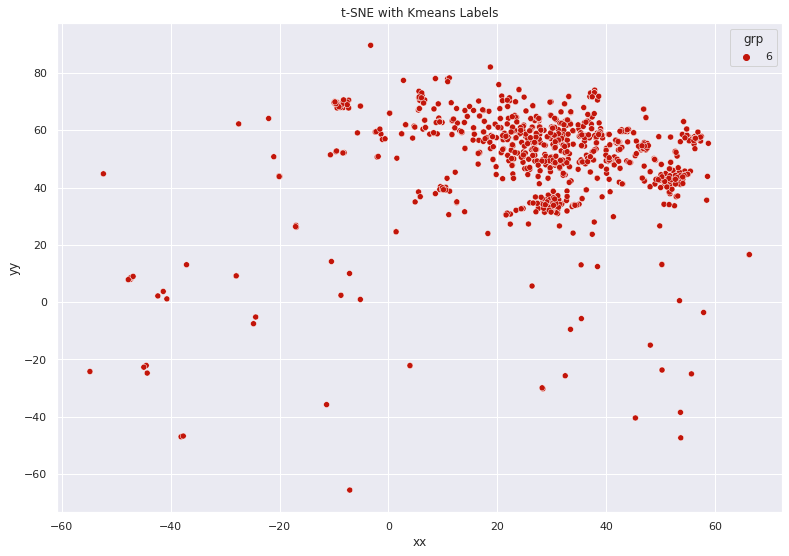

student, science, learning, program, engineering, technology, course, cybersecurity, woman, thinking, computing, college, equity, intervention, computational, undergraduate, instructor, biology, cyber, pandemic, organizational, career, faculty, datum, informal, disability, code, mentor, framework, change, nanotechnology, automotive, accessible, mathematic, hawaiian, grade, fellowship, fellow, food, mobile, covid-, blind, positive, stem, research, education, develop, skill



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


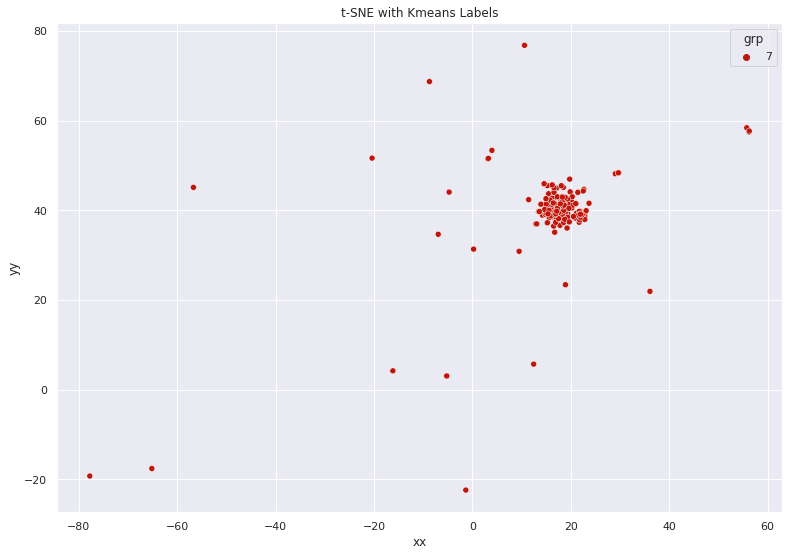

mentor, engineering, mathematical, edu, problem, rock, training, scientific, geoscience, experience, scholar, geo, material, participant, session, cuny, urban, site, brain, neuroscience, human, extreme, solar, weather, particle, developmental, admission, science, physics, play, project, occur, faculty, language, summer, community, stem, chemical, work, native, accessible, education, trainee, broaden, disseminate, orient, knowledge, direction



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


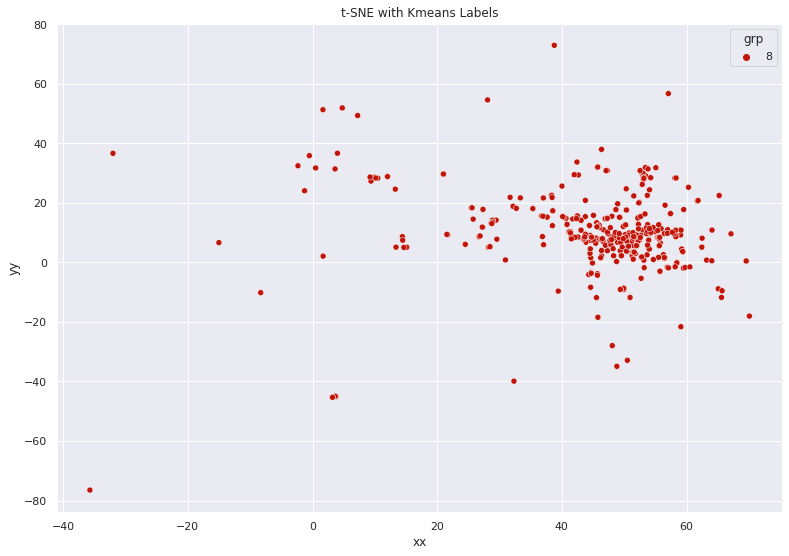

social, public, research, risk, project, influence, privacy, effect, health, family, school, learning, student, hurricane, user, contact, mental, norm, worker, science, epidemic, preference, model, patient, immune, rule, medical, law, solidarity, meeting, decision, crisis, descriptive, workshop, people, willingness, migration, biology, consensus, group, new, computational, interpersonal, deploy, unemployment, structured, consideration, analyst, physical, claim, investigator, response, disaster, trace



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


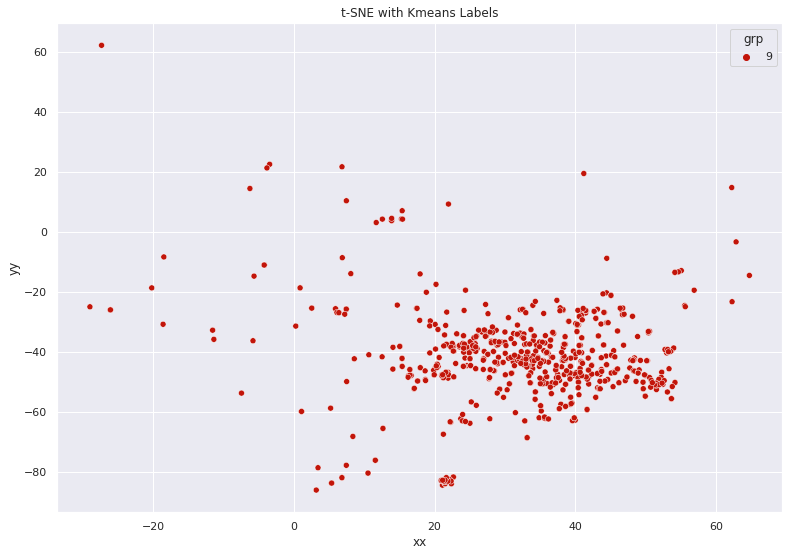

plant, specie, project, research, coral, datum, reef, disease, change, fungal, color, microbiome, male, rna, signal, ecosystem, flow, pathogen, tree, invasion, resistance, fluid, mosquito, warming, fish, endophyte, thermal, malaria, antarctic, event, plasticity, river, mammalian, light, trade, pattern, different, genome, identification, accurate, covid-, create, mimulus, copy, gene, palm, herbivore, testosterone, employ, neighbor, americans, biodiversity, community, host, parasite



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


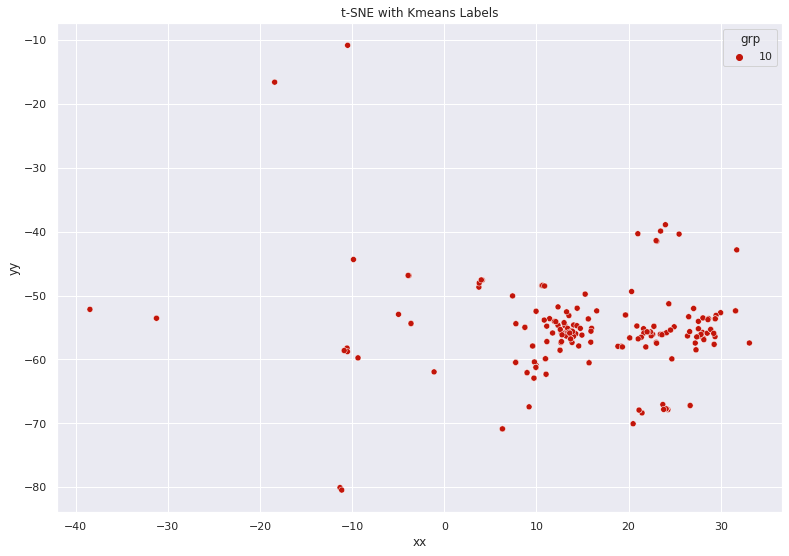

zone, tree, change, forest, process, datum, carbon, neon, organic, ectomycorrhizal, matter, model, water, management, uav, develop, ecosystem, research, spread, emission, lead, arctic, dust, community, transport, wind, exposure, industry, table, soil, smoke, plant, nitrogen, critical, microbial, science, growth, transform



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


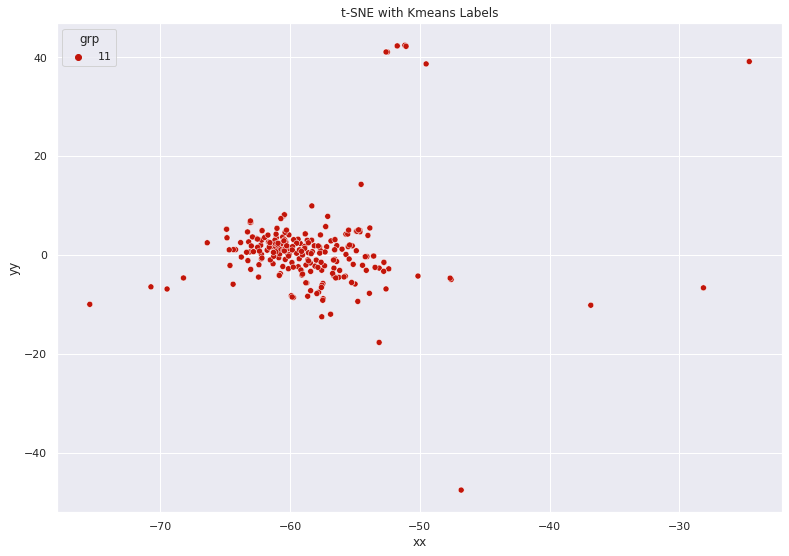

computer, photon, dot, technology, theory, photonic, research, network, study, communication, science, light, student, hall, fractional, probability, gravity, von, thermal, neumann, biology, control, gravitational, simulation, problem, biological, ultrafast, professor, pulse, dark, mechanic, objective, compound, nature, material, optical, receiver, medicine, video, identification, geometric, squeeze, hole, principle, simulator, electron, optimization, information, entanglement, state, thermodynamic, computing, project, spin, interaction, algorithm



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


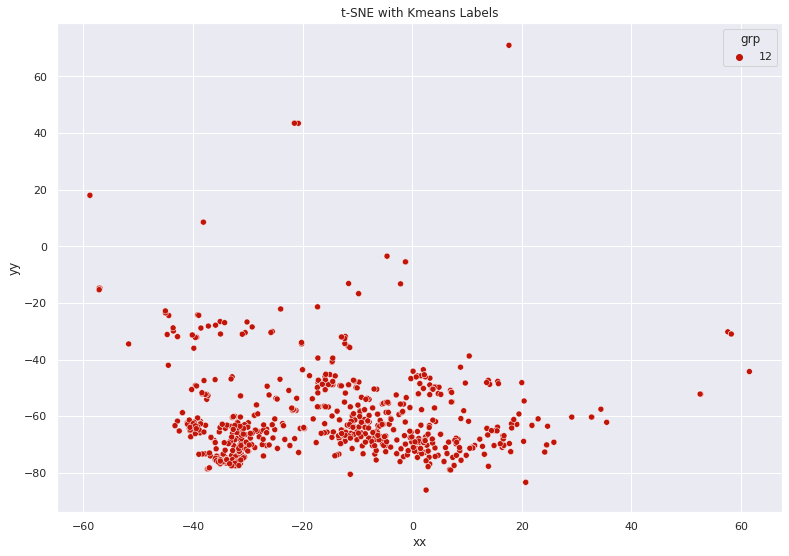

carbon, climate, change, earthquake, ocean, fault, seismic, magma, mantle, water, earth, plate, core, coastal, cloud, slip, river, heat, datum, specimen, wave, aerosol, research, air, plastic, doc, marine, stream, emission, coral, new, extinction, gas, oxide, landslide, record, recovery, nitrous, carbonate, hydrate, beach, microbiome, chemistry, production, participate, evolutionary, transition, seminar, pipe, global, lead, model, instability, flow, particle



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


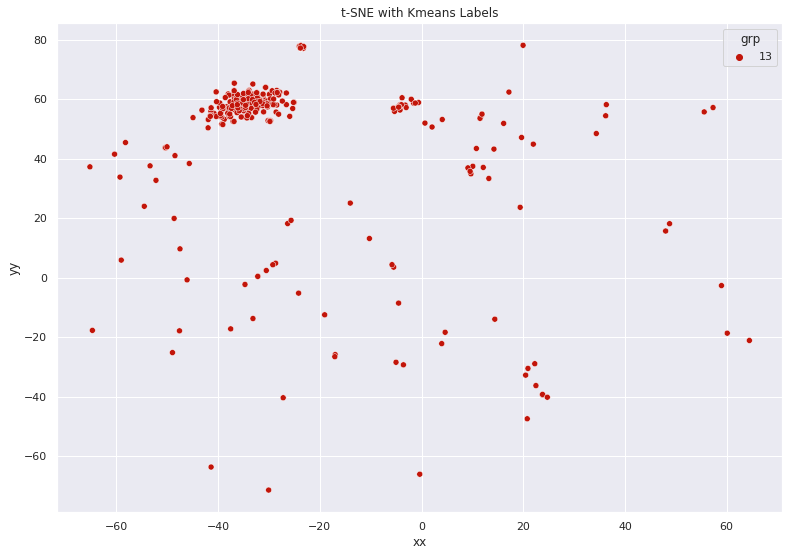

frontera, workshop, computing, theory, research, conference, group, science, learning, plant, language, geoscience, economic, polymer, participant, native, virtual, structural, numerical, datum, policy, scale, americans, solar, tectonic, signal, processing, theoretical, network, physics, methodological, economy, presenter, input, multidisciplinary, stem, university, subject, student, career, summer, leadership, meeting, area, field, transport, material, need, priority, mechanic, distinguished, cognitive



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


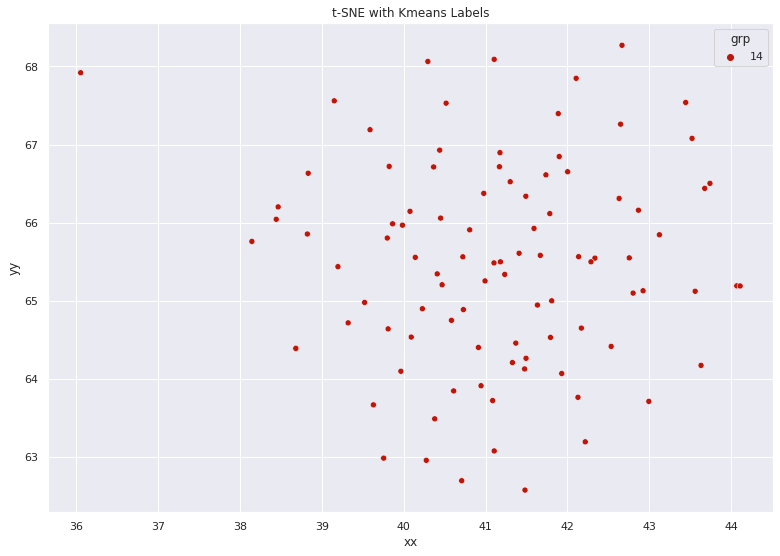

community, college, scholar, institutional, intelligence, computer, master, growth, plan, development, chemistry, generation, computing, responsive, professional, curricular, social, culturally, approach, rural, interaction, analysis, barrier, understanding, factor, achievement, include, activity, persistence, experience, service, study, mathematic, provide, leadership, belong, mentoring, scholars, cohort, university, conference, skill, institution, effectiveness, datum, follow, practice, framework, second, link, center, outreach, month, require



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


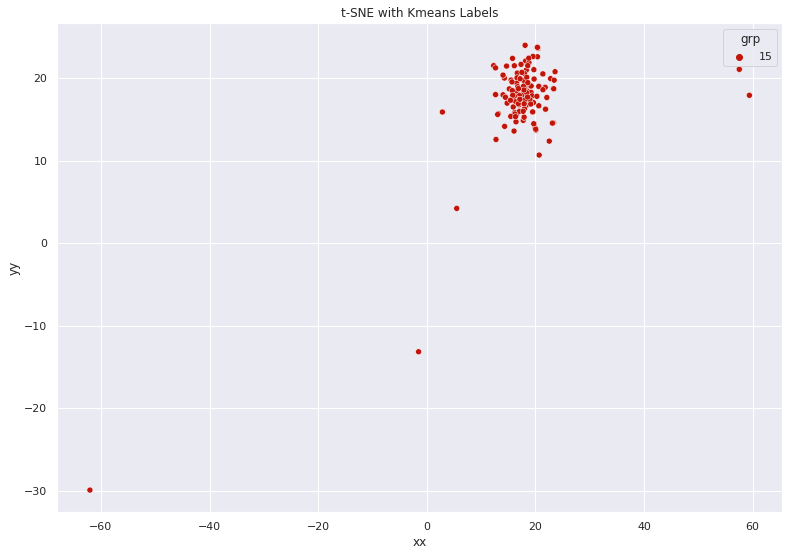

object, task, robotic, nursing, locomotion, environment, soft, research, interface, develop, generation, intelligent, wearable, worker, partnership, hypothesis, ocean, underwater, net, infrastructure, virtual, flow, dynamic, movement, muscle, fluid, reality, conference, manipulator, human, control, behavior, model, learn, design, user, student, simulation, manipulation, knowledge, video, constraint, adoption, bridge, preference, algorithm, sensor, solution, set, policy



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


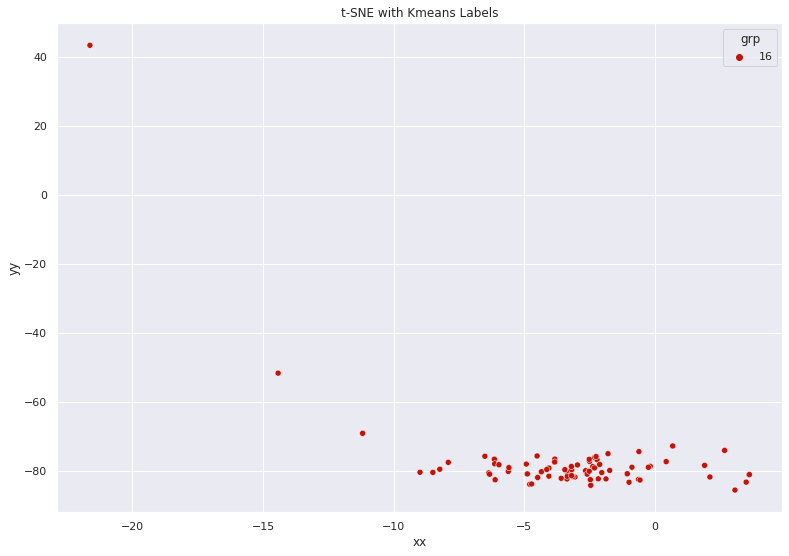

ocean, melt, glacier, level, greenland, snow, antarctic, chemical, shelf, network, firn, international, lake, datum, core, sample, era, subglacial, record, variability, dust, arctic, sediment, pollution, product, source, ecosystem, sea, land, condition, energy, volume, term, law, mixed, aircraft, light, crystal, southern, cloud, fjord, sheet, science, inaccessible, indicative, establish, colorado, amplification, organic



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


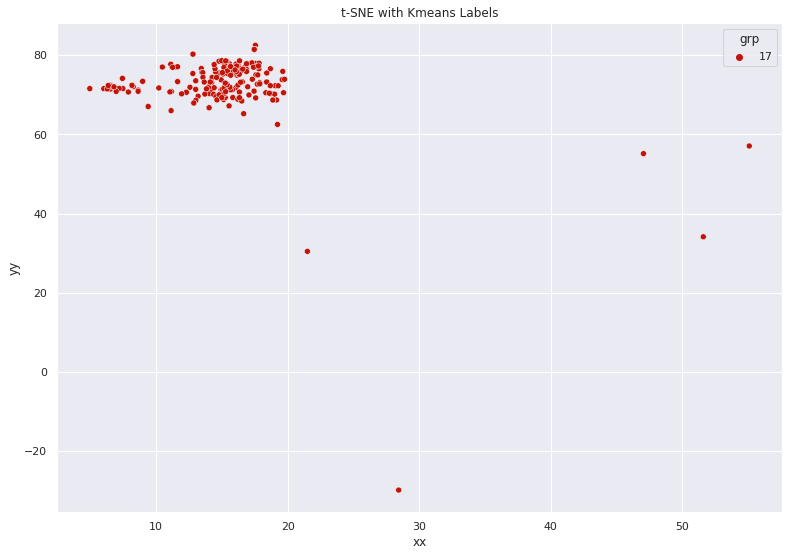

high, science, development, learning, rural, university, service, pre, school, computer, ecs, mathematical, preparation, scientific, model, coach, candidate, physics, energy, justice, newly, resource, disciplinary, computational, quality, unit, employment, profession, mentorship, curriculum, mentor, measure, washington, path, dataset, design, child, engineering, mathematic, education, knowledge, assessment, practice, create, modeling, stem, study, equitable, develop, touch, opportunity, job



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


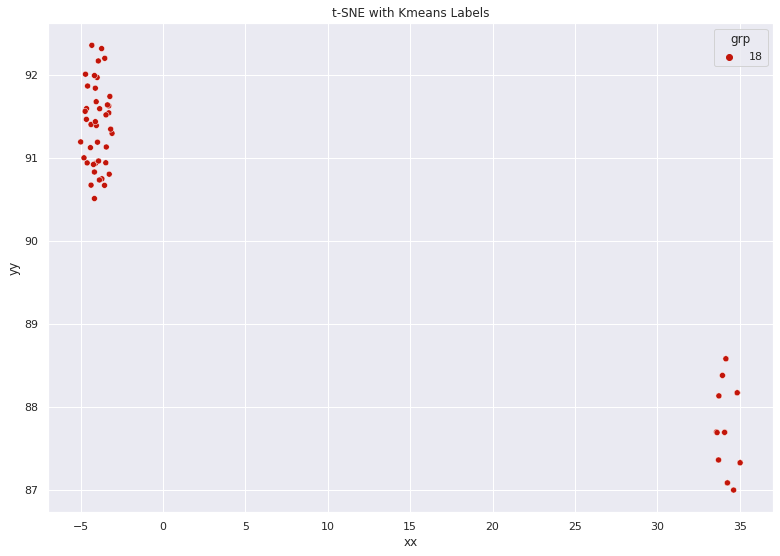

grfp, host, sponsor, scientist, mathematical, project, graduate, stem, education, mentorship, united, federal, degree, workforce, master, university, massachusetts, include, individual, student, fellowships, geometry, california, scientific, financial, vitality, highly, diversity, year, theory, pursue, mathematic, institute, base



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


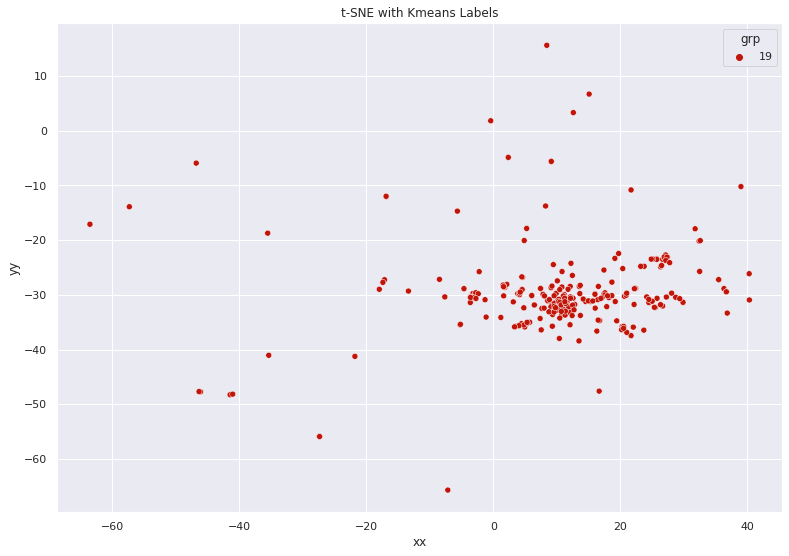

cell, develop, rna, enzyme, gene, iron, design, heme, brain, bacteria, bind, nmr, virus, ribosome, insect, phage, host, bacterial, research, signal, light, structure, nuclear, medium, nucleus, docking, experimental, ocean, purification, molecular, circuit, gut, sort, biogenesis, compartment, graph, data, maintenance, assembly, uniquely, self, community, growth, genome, microbe, model, stress, dna, interaction, study, membrane



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


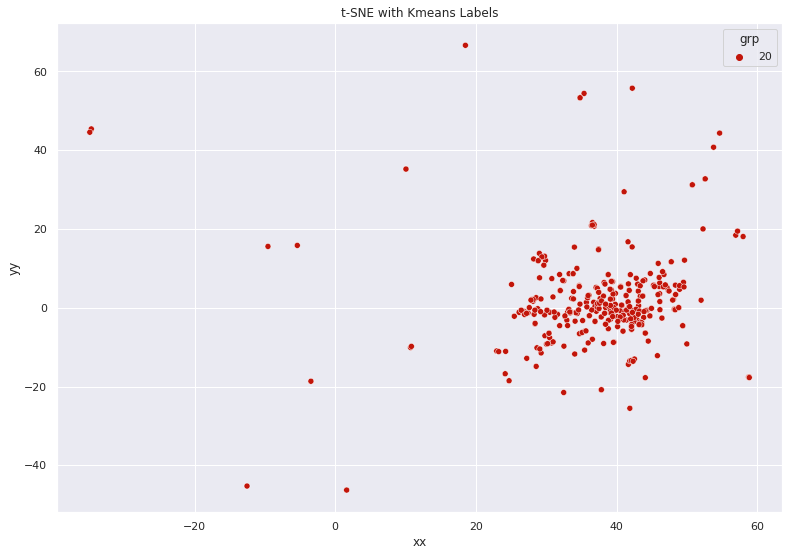

health, student, information, develop, base, infection, internet, network, image, lung, remote, innovation, child, computing, meeting, biological, chest, transmission, behavior, adult, neural, attitude, model, strain, testing, food, group, insecurity, literacy, foster, family, transportation, total, datum, prevention, disease, minority, public, people, pandemic, provide, level, spread, research, patient, healthy, trajectory, strategy, age, framework



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


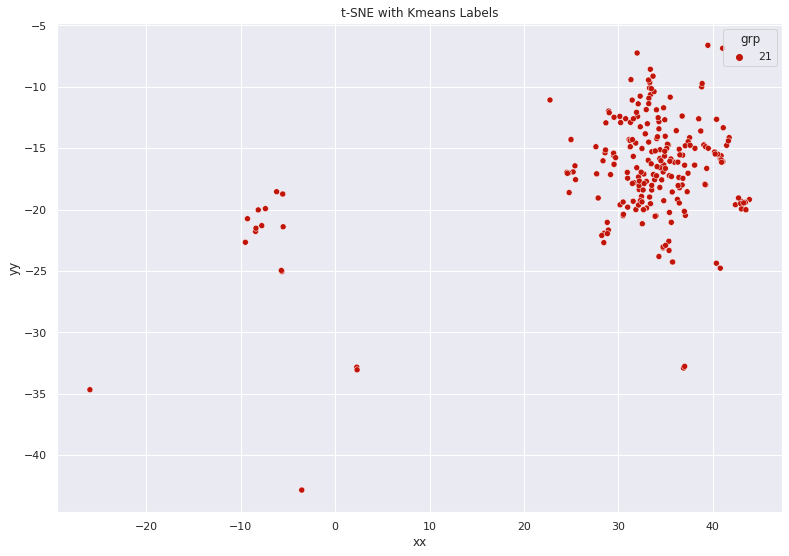

protein, transmission, human, bat, cov-, wastewater, immune, treatment, surface, plant, covid-, analysis, coating, sample, mask, cell, sensor, model, mucus, lung, method, thermal, personal, equipment, detection, nsp, instrument, disinfection, provide, spray, antibody, viral, polymer, host, device, research, outbreak, infectious, spread, disease, coronavirus, rna, genome



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


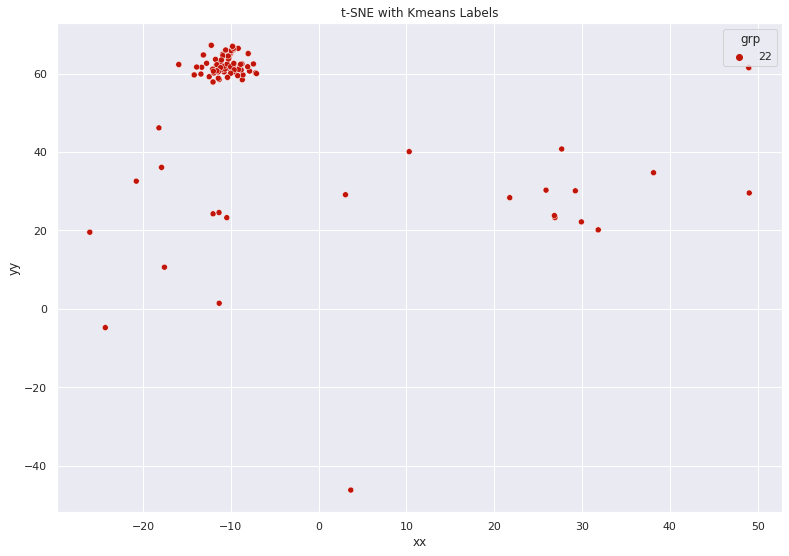

student, project, cybersecurity, human, datum, security, stem, state, community, group, ethical, cost, manufacturing, workshop, product, climate, national, base, store, space, way, physics, application, engineering, platform, model, interaction, research, design, innovation, science, machine, autonomous, intelligence, improve, skill, develop, decision, algorithm, trustworthy, solution, deep, planning, evaluate, come, natural, interface, bias, teaming, addition



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


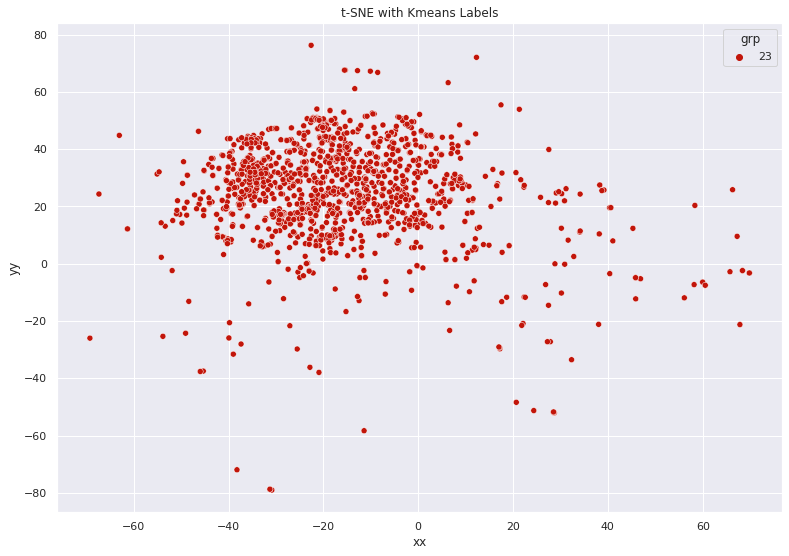

model, research, develop, science, wireless, software, problem, optimization, graph, control, power, vehicle, performance, tool, hardware, technique, neural, design, computing, sensor, grid, energy, compression, detection, database, dnn, brain, code, network, mobility, communication, testbed, causal, bit, anomaly, randomness, sleep, mass, inverter, solar, heat, crash, astronomical, police, aggregated, die, factor, modelling, resample, method, datum, spectrum, algorithm, cryptosystem, electricity, electric



In [93]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
K= range(0,24)  
# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(1, l=.4, s=.9)

for k in K:
  df1 = df[(df.grp == k) ]
  # plot
  sns.scatterplot(df1.xx, df1.yy, hue=df1.grp, legend='full', palette=palette)
  plt.title('t-SNE with Kmeans Labels')
  #plt.savefig("improved_cluster_tsne_1.png")
  plt.show()
  print(topics[k])

Es interesante ver que el grupo 16 presenta las siguientes palabras: "ocean, melt, glacier, level, greenland, snow, antarctic, chemical" que se relacionan con cambio climático y descongelamiento de los glaciares en el antártico

## Conclusión

La idea de este cuaderno era implementar las técnicas de modelado de temas más utilizadas y compararlas. Así, LDA es la técnica más utilizada y se considera consistente ya que es probable que proporcione temas más "coherentes". 